In [1]:
!git clone https://github.com/AbrahamCamelo/ResearchMethods_GitHub.git

Cloning into 'ResearchMethods_GitHub'...
remote: Enumerating objects: 503, done.
remote: Counting objects: 100% (503/503), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 503 (delta 418), reused 451 (delta 395), pack-reused 0 (from 0)
Receiving objects: 100% (503/503), 2.55 MiB | 6.48 MiB/s, done.
Resolving deltas: 100% (418/418), done.


In [2]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


Import the dataset

In [4]:
df_average = pd.read_csv('ResearchMethods_GitHub/ndvi_data/average_ndvi.csv')
df_average['date'] = pd.to_datetime(df_average.date)
df_average = df_average.drop(columns=['Unnamed: 0'])
lst_ndvi = np.array(df_average.NDVI)

In [5]:
n_steps_in = 23
n_steps_out = 1

In [6]:
scaler = MinMaxScaler()
lst_ndvi = scaler.fit_transform(lst_ndvi.reshape(-1, 1))

#### Function to restructure the data for the model

In [7]:
def prepare_data(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out):
        X.append(data[i:i+n_steps_in])
        y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out])
    return np.array(X), np.array(y)

In [8]:
X, y = prepare_data(lst_ndvi, n_steps_in, n_steps_out)

## Keras tune
*   Definition of an integer hyperparameter: hp.Int(*hyperparameter*, min_value=#, max_value=#, step=#). This means that the *hyperparameter* will range from *min_value* to *max_value* inclusive with the minimum step for walking through the interval being *step*.

### Compile
Configures the model for training.

**Hyperparameters**
* **optimizer**: String (name of optimizer) or optimizer instance. Related to back propagation.
* **loss**: Loss function. fn(y_true, y_pred)
* **metrics**: List of metrics to be evaluated by the model during training and testing.

It looks like loss is for the fitting of the model and metrics is for the final evaluation.



In [9]:
def build_model_1layer(hp):
    model = Sequential()
    model.add(
        LSTM(units=hp.Int(f"units_0", min_value=10, max_value=100, step=10),
             activation='tanh',
             input_shape=(n_steps_in, 1)
             )
        )
    model.add(Dense(n_steps_out))
    model.compile(
        optimizer= Adam(learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='mean_squared_error',
        metrics = ['root_mean_squared_error']
    )
    return model

### To initialize the tuner

* **hypermodel**. The model-building function, which is build_model in our case.
* **objective**. The name of the objective to optimize.
* **max_trials**. The total number of trials to run during the search. Different trials have different hyperparameter values.
* **executions_per_trial**. The number of models that should be built and fit for each trial. It is like cross-validation.
* **overwrite**. Control whether to overwrite the previous results in the same directory or resume the previous search instead.
* **directory**. A path to a directory for storing the search results.
* **project_name**. The name of the sub-directory in the directory.

In [ ]:
!rm -rf /content/lstm_tuning

In [66]:
tuner_1layer = kt.RandomSearch(
    build_model_1layer,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=3,
    directory='/content/drive/MyDrive/Master/lstm_tuning',
    project_name='1layer'
)
tuner_1layer.search_space_summary()

Reloading Tuner from /content/drive/MyDrive/Master/lstm_tuning/1layer/tuner0.json
Search space summary
Default search space size: 2
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(91, 23, 1)

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=14, restore_best_weights=True)

In [15]:
tuner_1layer.search(X_train, y_train, epochs=40, validation_data=(X_val, y_val), callbacks=[early_stop])

Show the sumary of the results

In [67]:
a = tuner_1layer.results_summary()
#print(type(a))


Results summary
Results in /content/drive/MyDrive/Master/lstm_tuning/1layer
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 29 summary
Hyperparameters:
units_0: 80
lr: 0.008223713071187294
Score: 0.010433348516623179

Trial 06 summary
Hyperparameters:
units_0: 50
lr: 0.005664964099532701
Score: 0.010719900640348593

Trial 22 summary
Hyperparameters:
units_0: 100
lr: 0.007386760578782742
Score: 0.011130868767698606

Trial 19 summary
Hyperparameters:
units_0: 50
lr: 0.005813110971528378
Score: 0.011199558464189371

Trial 46 summary
Hyperparameters:
units_0: 90
lr: 0.007305354737589493
Score: 0.011426099576056004

Trial 01 summary
Hyperparameters:
units_0: 20
lr: 0.0089052720290065
Score: 0.011427219646672407

Trial 13 summary
Hyperparameters:
units_0: 30
lr: 0.006336077696202977
Score: 0.012124338497718176

Trial 45 summary
Hyperparameters:
units_0: 20
lr: 0.006759509436305564
Score: 0.013716522293786207

Trial 33 summary
Hyperparameters:
units_0: 90
lr: 0.00236

Best result so far:
* units: 40
* lr: 0.00976844384018483
* Score: 0.01515659037977457

The other best result is
num_layers: 1
units_0: 60
lr: 0.006429326855520711
units_1: 20
units_2: 100
Score: 0.018751021474599838

In [54]:
# Retrieve all trials from the tuner
trials = tuner_1layer.oracle.get_best_trials(num_trials=50)

# Initialize lists for hyperparameters and scores
units_0_list = []
lr_list = []
score_list = []

# Loop through each trial to extract information
for trial in trials:
    hyperparameters = trial.hyperparameters.values
    units_0_list.append(hyperparameters.get("units_0"))
    lr_list.append(hyperparameters.get("lr"))
    score_list.append(trial.score)

# The lists are now in order of the trials
print("Units_0:", units_0_list)
print("Learning Rates:", lr_list)
print("Scores:", score_list)

Units_0: [80, 50, 100, 50, 90, 20, 30, 20, 90, 60, 30, 80, 50, 60, 30, 100, 40, 50, 30, 80, 40, 90, 10, 10, 50, 20, 10, 80, 40, 30, 90, 40, 60, 60, 60, 40, 30, 60, 20, 50, 80, 90, 100, 80, 20, 80, 50, 20, 20, 20]
Learning Rates: [0.008223713071187294, 0.005664964099532701, 0.007386760578782742, 0.005813110971528378, 0.007305354737589493, 0.0089052720290065, 0.006336077696202977, 0.006759509436305564, 0.0023699044940759216, 0.003041963621230303, 0.0048429955437811825, 0.002386422384928134, 0.0025783877510808387, 0.002250984658023531, 0.0027925570846360714, 0.0019218776960015956, 0.0025510751612212845, 0.002053040292245905, 0.0018516174658228268, 0.0017845434584725045, 0.0016528518972563707, 0.0012008601894291048, 0.004545416702014981, 0.0030235992106009313, 0.001030132438265666, 0.0009869107559338007, 0.0023889707765900976, 0.0005276965876741727, 0.0007341550068485831, 0.0007938551864387135, 0.00047197417583353795, 0.0005367136238614067, 0.00034268604008720995, 0.0004375332735893259, 0.

In [59]:
pd.DataFrame({u'units_0': units_0_list, u'lr': lr_list, u'score': score_list}).to_csv('/content/models1_layer.csv', index=False)


In [76]:
best_model_1layer = tuner_1layer.get_best_models(num_models=1)[0]
history = best_model_1layer.fit(X, y, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0218 - root_mean_squared_error: 0.1456 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1629
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0179 - root_mean_squared_error: 0.1337 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0123 - root_mean_squared_error: 0.1094 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1274
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0109 - root_mean_squared_error: 0.1046 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0123 - roo

In [69]:
print(root_mean_squared_error(y.flatten(), best_model_1layer.predict(X).flatten()))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0.09925230402273995


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


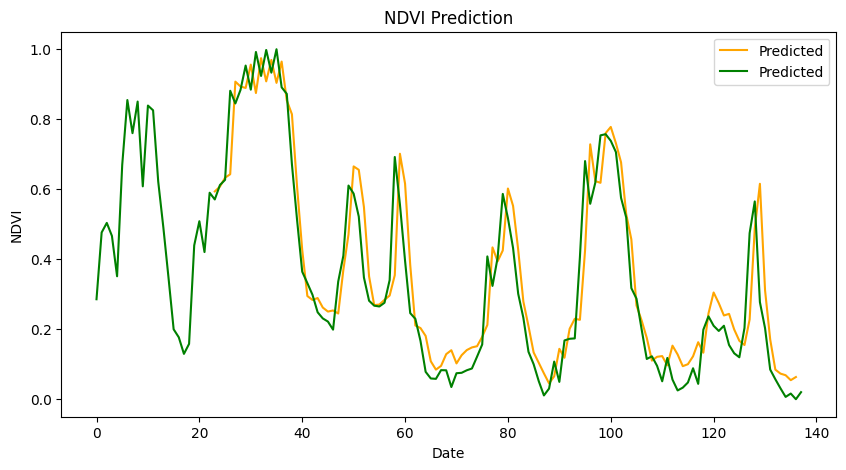

In [75]:
Total_pred = best_model_1layer.predict(X)
plt.figure(figsize=(10,5))
plt.plot(range(len(lst_ndvi)-len(Total_pred)-1,len(lst_ndvi)-1),Total_pred, label = 'Predicted', c = 'orange')
plt.plot(lst_ndvi, label = 'Predicted', c = 'green')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('NDVI Prediction')
plt.legend()
#plt.plot(np.concatenate((lst_ndvi,predictions)), label = 'Predicted', c = 'green')
plt.show()

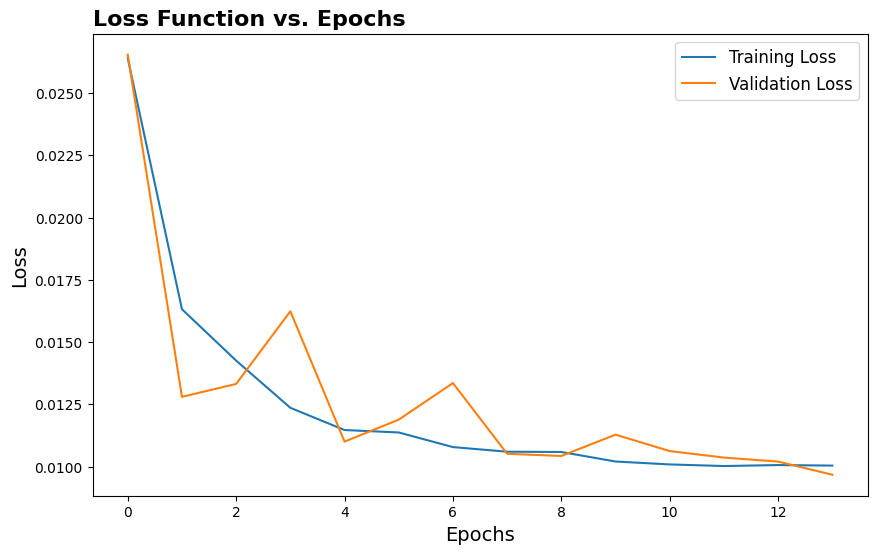

In [78]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Function vs. Epochs', fontsize=16, fontweight='bold', loc='left')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
#plt.grid(True)
plt.show()

## 2 Layers

In [ ]:
def build_model_2layer(hp):
    model = Sequential()
    cells = hp.Int(f"units_0", min_value=10, max_value=100, step=10)
    model.add(
        LSTM(units=cells,
             activation='tanh',
             input_shape=(n_steps_in, 1),
             return_sequences=True
             )
        )
    model.add(
        LSTM(units=cells,
             activation='tanh'
             )
        )
    model.add(Dense(n_steps_out))
    model.compile(
        optimizer= Adam(learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='mean_squared_error',
        metrics = ['root_mean_squared_error']
    )
    return model


tuner_2layer = kt.RandomSearch(
    build_model_2layer,
    objective='val_loss',
    max_trials=40,
    executions_per_trial=3,
    directory='lstm_tuning',
    project_name='2layer'
)
tuner_2layer.search_space_summary()

tuner_2layer.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])


Trial 40 Complete [00h 00m 40s]
val_loss: 0.05589477593700091

Best val_loss So Far: 0.01904242734114329
Total elapsed time: 00h 23m 26s


In [ ]:
tuner_2layer.search_space_summary()


Search space summary
Default search space size: 2
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner_2layer.get_best_hyperparameters(1)[0].values
best_model_2layer = tuner_2layer.get_best_models(num_models=1)[0]
best_model_2layer.fit(X, y, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])
print(root_mean_squared_error(y.flatten(), best_model_2layer.predict(X).flatten()))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - loss: 0.0296 - root_mean_squared_error: 0.1692 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1928
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0407 - root_mean_squared_error: 0.2006 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1720
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1384
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0182 - root_mean_squared_error: 0.1348 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1565
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0152 - root_mean_squared_error: 0.1234 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0138 - root_mean_squa

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


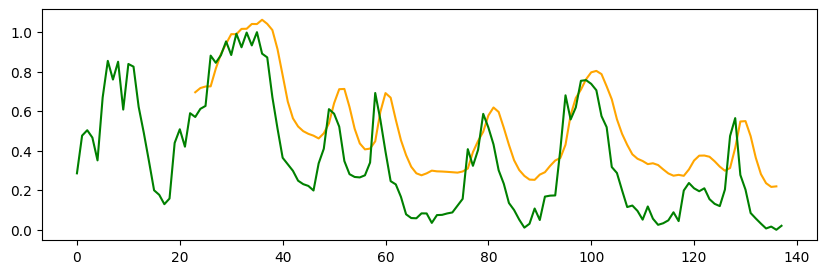

In [ ]:
Total_pred = best_model_2layer.predict(X)
plt.figure(figsize=(10,3))
plt.plot(range(len(lst_ndvi)-len(Total_pred)-1,len(lst_ndvi)-1),Total_pred, label = 'Predicted', c = 'orange')
plt.plot(lst_ndvi, label = 'Predicted', c = 'green')
plt.show()

In [ ]:
best_model_2layer.summary()
tuner_2layer.get_best_hyperparameters(1)[0].values

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 23, 80)              │          26,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 80)                  │          51,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,525 (912.21 KB)

 Trainable params: 77,841 (304.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 155,684 (608.14 KB)

{'units_0': 80, 'lr': 0.0014951135160520678}

## 3 Layers

In [ ]:
def build_model_3layer(hp):
    model = Sequential()
    model.add(
        LSTM(units=hp.Int(f"units_0", min_value=10, max_value=100, step=10),
             activation='tanh',
             input_shape=(n_steps_in, 1),
             return_sequences=True
             )
        )
    model.add(
        LSTM(units=hp.Int(f"units_1", min_value=10, max_value=100, step=10),
             activation='tanh',
             return_sequences=True
             )
        )
    model.add(
        LSTM(units=hp.Int(f"units_2", min_value=10, max_value=100, step=10),
             activation='tanh'
             )
        )
    model.add(Dense(n_steps_out))
    model.compile(
        optimizer= Adam(learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='mean_squared_error',
        metrics = ['root_mean_squared_error']
    )
    return model


tuner_3layer = kt.RandomSearch(
    build_model_3layer,
    objective='val_loss',
    max_trials=40,
    executions_per_trial=3,
    directory='lstm_tuning',
    project_name='3layer'
)
tuner_3layer.search_space_summary()

tuner_3layer.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])


In [ ]:
tuner_3layer.get_best_hyperparameters(1)[0].values
best_model_3layer = tuner_3layer.get_best_models(num_models=1)[0]
best_model_3layer.fit(X, y, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stop])
print(root_mean_squared_error(y.flatten(), best_model_3layer.predict(X).flatten()))

In [ ]:
Total_pred = best_model_3layer.predict(X)
plt.figure(figsize=(10,3))
plt.plot(range(len(lst_ndvi)-len(Total_pred)-1,len(lst_ndvi)-1),Total_pred, label = 'Predicted', c = 'orange')
plt.plot(lst_ndvi, label = 'Predicted', c = 'green')
plt.show()

## Export data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/Master/lstm_tuning'